In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt

In [3]:
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
start_date = "20230409"
end_date = "20230419"
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"

# Observations

## SOS towers

In [4]:
sos_df = pd.read_parquet("../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet")
sos_df_localtime = utils.modify_df_timezone(
    sos_df,
    'UTC',
    'US/Mountain'
)


In [5]:
sos_relevant_netcdf_files = sorted(glob.glob('/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/*.nc'))[159:170]

In [6]:
# OPEN NETCDFS so we can use 5 minute skewnesss
datasets = []
# for april 9 - 19
sos_relevant_netcdf_files = sorted(glob.glob('/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/*.nc'))[159:170]
# for march 4 - 8
# sos_relevant_netcdf_files = sorted(glob.glob('/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/*.nc'))[123:128]
# for dec 21-22
# sos_relevant_netcdf_files = sorted(glob.glob('/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_isfs_qc_geo_tiltcor_5min_v20241227/*.nc'))[50:52]
for file in sos_relevant_netcdf_files:
    ds = xr.open_dataset(file)
    datasets.append(ds)

sos_ds = xr.concat(datasets, dim='time')

In [7]:
days_list = [(pd.to_datetime(start_date) + dt.timedelta(days=i)).strftime('%Y-%m-%d') 
             for i in range((pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1)]

print(days_list)

['2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19']


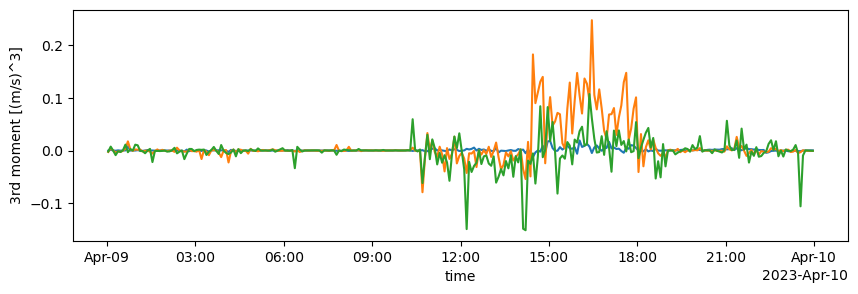

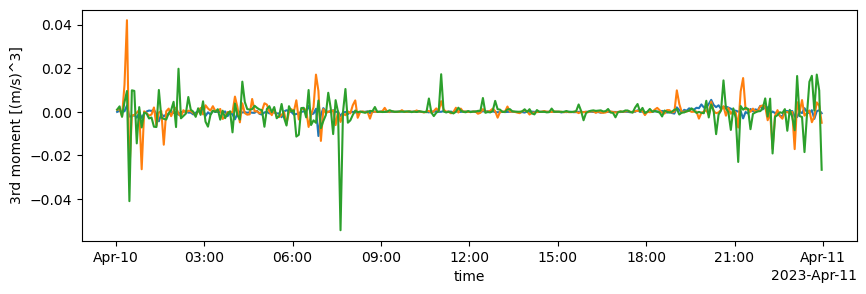

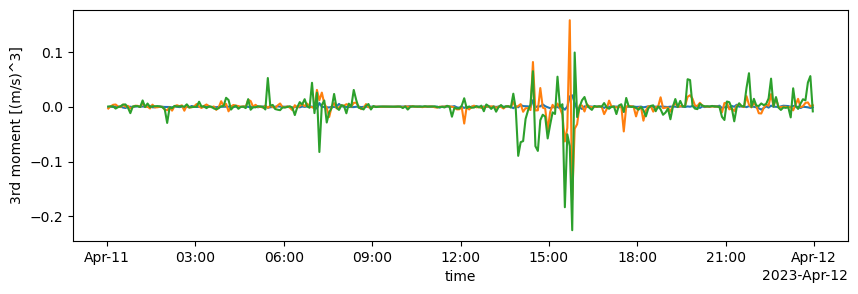

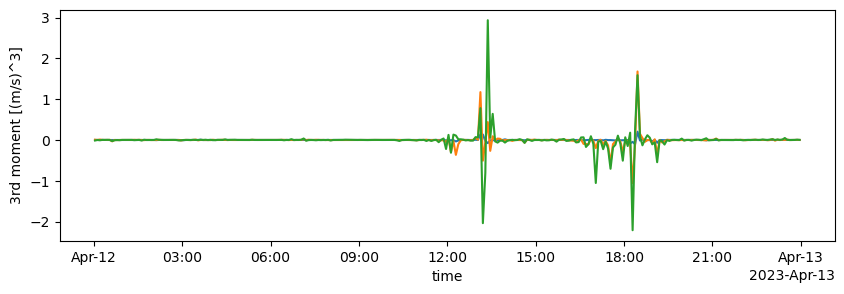

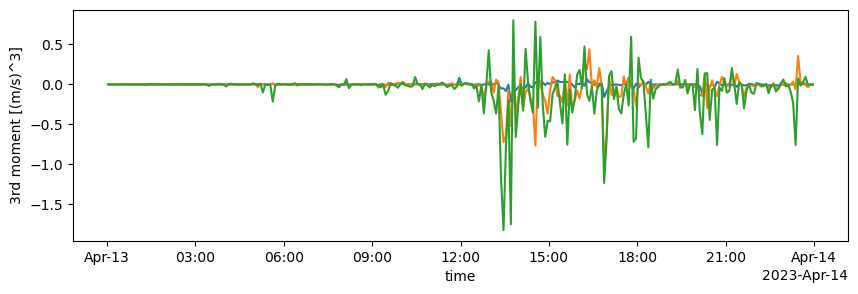

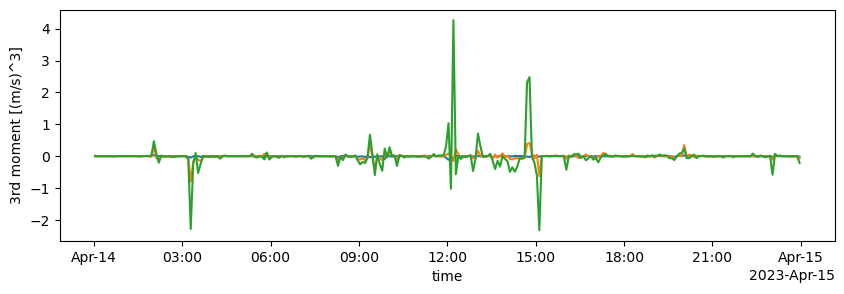

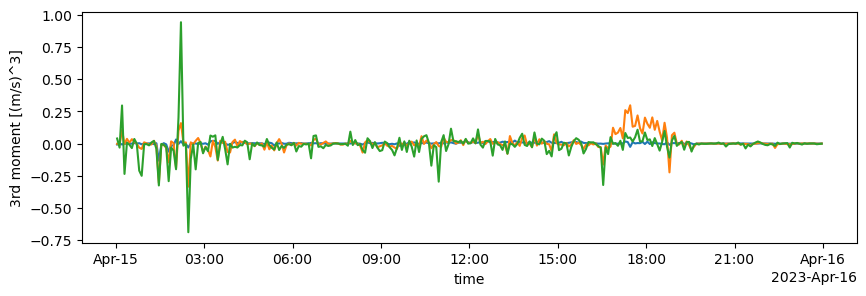

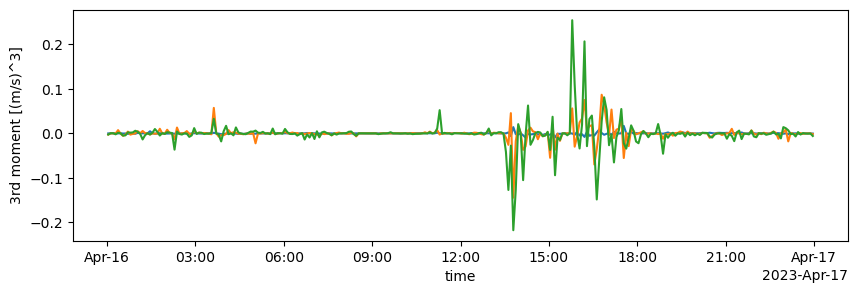

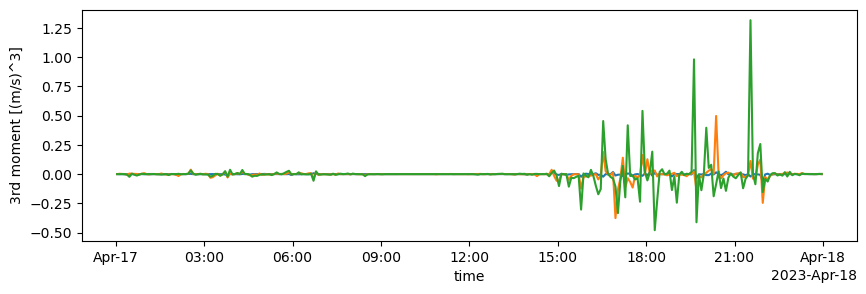

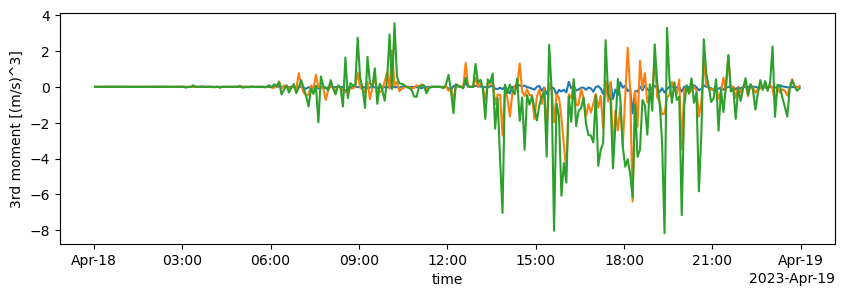

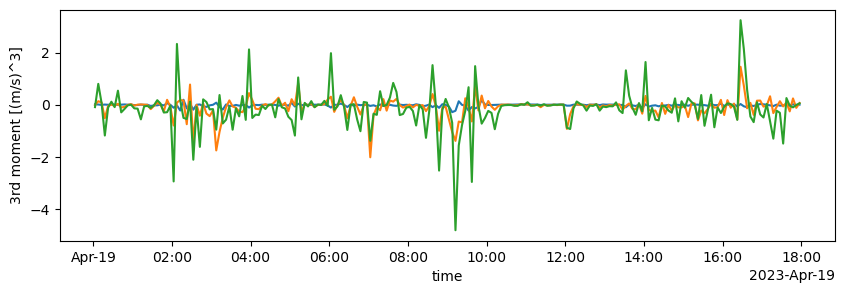

In [8]:
sos_ds_localtime = utils.modify_xarray_timezone(
        sos_ds,
        'UTC',
        'US/Mountain'
    )
for day in days_list:
    
    this_day_dataset = sos_ds_localtime.sel(time=slice(
        dt.datetime.strptime(day, '%Y-%m-%d'), 
        dt.datetime.strptime(day, '%Y-%m-%d') + dt.timedelta(days=1)
    ))
    this_day_dataset['w_w_w__3m_c'].plot(figsize=(10,3))
    this_day_dataset['w_w_w__10m_c'].plot(ax=plt.gca())
    this_day_dataset['w_w_w__20m_c'].plot(ax=plt.gca())
    plt.show()

## SAIL doppler lidar VS mode

In [9]:
# Inputs
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)
file_list = act.discovery.download_arm_data(
    username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR
    )

ARM Data Live Webservice does not appear to be functioning


In [10]:
file_list = [f for f in glob.glob(os.path.join(data_dir, DLW_DATA_STREAM, '*.nc')) if '20230418' in f or '20230419' in f]

In [11]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

Text(0.5, 1.0, 'Vertical velocity variance from vertically-staring Doppler Lidar')

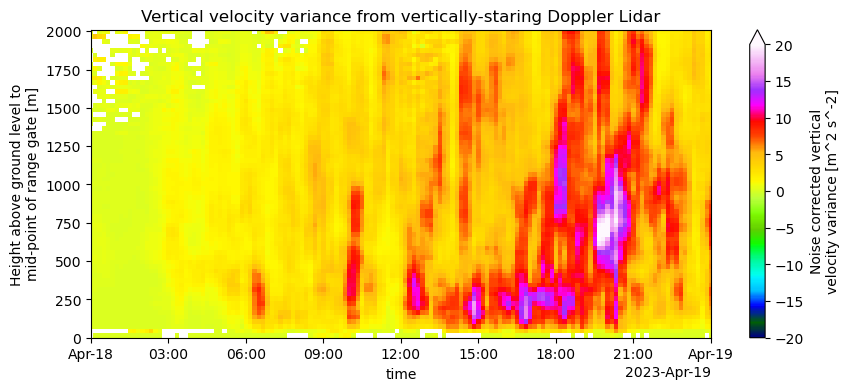

In [12]:
dl_wstats.sel(height = slice(0,2000))['w_variance'].plot(x = 'time', y='height', figsize=(10,4), vmin=-20, vmax=20, cmap='gist_ncar')
plt.xlim('20230418 0000', '20230419 0000')
plt.title('Vertical velocity variance from vertically-staring Doppler Lidar')

Text(0.5, 1.0, 'Vertical velocity variance from vertically-staring Doppler Lidar')

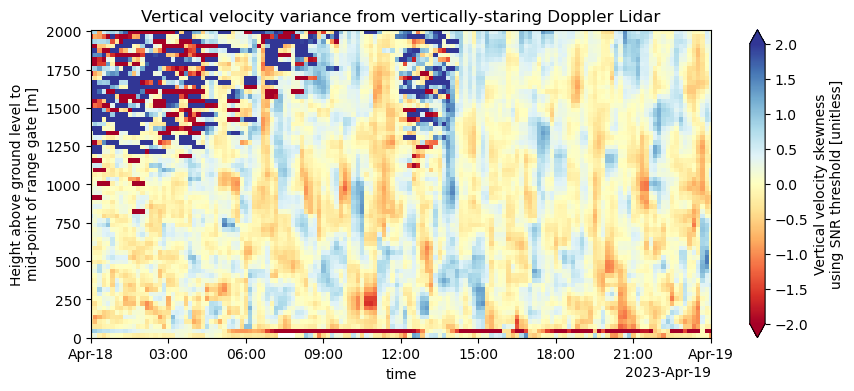

In [13]:
dl_wstats.sel(height = slice(0,2000))['w_skewness'].plot(x = 'time', y='height', figsize=(10,4), vmin=-2, vmax=2, cmap='RdYlBu')
plt.xlim('20230418 0000', '20230419 0000')
plt.title('Vertical velocity variance from vertically-staring Doppler Lidar')

In [14]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
src

,height,snr,snr_25,snr_75,w,w_25,w_75,noise,w_variance,w_skewness,...,ecor_alt,met_spr_mean,met_spr_min,met_spr_max,met_lat,met_lon,met_alt,lat,lon,alt
time,,,,,,,,,,,,,,,,,,,,,
2023-04-18,15.0,0.075394,0.015212,0.105783,0.058391,0.002488,0.108361,0.624373,0.001732,0.074796,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-18,45.0,0.019147,0.016097,0.022605,-2.795504,-3.146167,6.402348,20.927858,NaN,0.865277,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-18,75.0,0.021970,0.019706,0.024225,0.019287,-0.174226,0.202699,0.016875,0.078971,-0.258484,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-18,105.0,0.024103,0.021556,0.026239,0.046528,-0.167067,0.225375,0.017280,0.077467,-0.424877,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-18,135.0,0.022158,0.019928,0.024385,0.026509,-0.199043,0.204663,0.017712,0.088023,-0.607702,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-19,1875.0,0.371584,0.062160,0.816072,-0.086235,-1.174354,1.450086,0.013057,2.639753,0.253067,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-19,1905.0,0.420225,0.071016,0.794001,0.024853,-1.051465,1.523980,0.010920,2.533217,0.220491,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0
2023-04-19,1935.0,0.429698,0.083434,0.813945,0.094843,-1.045726,1.495045,0.016472,2.498111,0.317148,...,2886.0,0.0,0.0,0.0,38.956158,-106.987854,2886.0,38.9561,-106.987831,2886.0


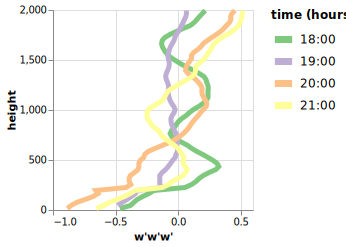

In [15]:
alt.Chart(
    src[src.snr > 0.008].loc['20230418 1800': '20230418 2159'].reset_index()
).mark_line(strokeWidth=5).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'"),
    alt.Y('height:Q'),
    alt.Color('hours(time):O').scale(scheme='accent'),
    order='height:Q'
).configure_legend(
    titleFontSize=12,  # Adjust title font size
    labelFontSize=12,  # Adjust label font size
    symbolSize=300,
    symbolStrokeWidth=7   # Adjust symbol size
).properties(width=200, height=200).display(renderer='svg')

## SAIL Radiosonde Data

In [16]:
# Define the data code and date range
data_code = 'gucsondewnpnM1.b1'
# Download the data
# files = act.discovery.download_arm_data(
#     username,
#     token,
#     data_code,
#     start_date,
#     end_date,
#     output = os.path.join(data_dir, data_code)
# )
# files = sorted(files)

In [17]:
files = pd.Series([start_date,end_date]).apply(
    lambda d: glob.glob(os.path.join(data_dir, data_code, f"*{d}*.cdf"))
)
files = sorted(list((files).explode()))
files

['/Users/elischwat/Development/data/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230409.113200.cdf',
 '/Users/elischwat/Development/data/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230409.232800.cdf',
 '/Users/elischwat/Development/data/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230419.113000.cdf',
 '/Users/elischwat/Development/data/sublimationofsnow/gucsondewnpnM1.b1/gucsondewnpnM1.b1.20230419.233100.cdf']

In [18]:
sondes_ds = xr.open_mfdataset(files)
sondes_df = sondes_ds.to_dataframe().reset_index()
sondes_df = utils.modify_df_timezone(sondes_df, 'UTC', 'US/Mountain')
sondes_df['date'] = sondes_df.time.dt.date.astype(str)
sondes_df['hour'] = sondes_df.time.dt.hour
sondes_df['timeofday'] = (sondes_df['hour'] < 12).apply(lambda is_morning: 'Morning' if is_morning else 'Afternoon')

## Gothic Sail Tower data

In [53]:
# Define the data codes for meteorological and turbulence data
data_codes = [
    'gucmetM1.b1',  # Example data code for meteorological data
    'guc30ecorM1.b1'  # Example data code for turbulence data
]

# Loop through each data code and download the data
data_dict = {}
for data_code in data_codes:
    files = act.discovery.download_arm_data(
        username,  # Replace with your ARM username
        token,        # Replace with your ARM token
        data_code,
        start_date,
        end_date,
        output = os.path.join(data_dir, data_code)
    )
    print(files)
    # Load the data into an ACT object and append to the list
    ds = act.io.read_arm_netcdf(files)
    data_dict[data_code] = ds

gothic_met = data_dict[data_codes[0]]
gothic_ec = data_dict[data_codes[1]]

ARM Data Live Webservice does not appear to be functioning
[]


OSError: no files to open

In [20]:
from datetime import datetime, timedelta

def generate_date_range(start_date, end_date):
    # Parse the input dates
    start = datetime.strptime(start_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    
    # Generate the list of dates
    date_list = []
    current_date = start
    while current_date <= end:
        date_list.append(current_date.strftime('%Y%m%d'))
        current_date += timedelta(days=1)
    
    return date_list
dates = generate_date_range(start_date, end_date)
dates

['20230409',
 '20230410',
 '20230411',
 '20230412',
 '20230413',
 '20230414',
 '20230415',
 '20230416',
 '20230417',
 '20230418',
 '20230419']

In [61]:

files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, 'guc30ecorM1.b1', f"*{d}*.cdf"))
)
files = sorted(list((files).explode()))
sail_ecor_ds = xr.open_mfdataset(files)
sail_ecor_df = sail_ecor_ds.to_dataframe().reset_index()
sail_ecor_df_localtime = utils.modify_df_timezone(sail_ecor_df, 'UTC', 'US/Mountain')
sail_ecor_df_localtime = sail_ecor_df_localtime.query("bound == 0") ##???
sail_ecor_df_localtime

,time,bound,base_time,time_offset,time_bounds,mean_u,qc_mean_u,mean_v,qc_mean_v,mean_w,...,mean_spk_t,mean_spk_q,mean_spk_c,n_bad_sonic,n_bad_irga,n_bad_irga_light,mean_cooler,lat,lon,alt
0,2023-04-08 18:00:00,0,2023-04-09,2023-04-09 00:00:00,2023-04-08 23:30:00,0.3119,0,0.06288,0,-0.004526,...,282.200012,NaN,10.380,0.0,0.0,0.0,1.265,38.956158,-106.987854,2886.0
2,2023-04-08 18:30:00,0,2023-04-09,2023-04-09 00:30:00,2023-04-09 00:00:00,-0.6898,0,0.15810,0,-0.005108,...,NaN,NaN,10.380,0.0,0.0,0.0,1.254,38.956158,-106.987854,2886.0
4,2023-04-08 19:00:00,0,2023-04-09,2023-04-09 01:00:00,2023-04-09 00:30:00,-0.3908,0,-1.04100,0,0.013960,...,NaN,NaN,10.320,0.0,0.0,0.0,1.247,38.956158,-106.987854,2886.0
6,2023-04-08 19:30:00,0,2023-04-09,2023-04-09 01:30:00,2023-04-09 01:00:00,-0.8409,0,0.04252,0,0.003995,...,NaN,NaN,10.130,0.0,0.0,0.0,1.222,38.956158,-106.987854,2886.0
8,2023-04-08 20:00:00,0,2023-04-09,2023-04-09 02:00:00,2023-04-09 01:30:00,-0.2776,0,0.70870,0,-0.026300,...,NaN,NaN,9.607,0.0,0.0,0.0,1.204,38.956158,-106.987854,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,2023-04-19 15:30:00,0,2023-04-19,2023-04-19 21:30:00,2023-04-19 21:00:00,-4.6050,0,0.83110,0,-0.082890,...,283.299988,236.399994,10.460,39.0,0.0,0.0,1.167,38.956158,-106.987854,2886.0
1048,2023-04-19 16:00:00,0,2023-04-19,2023-04-19 22:00:00,2023-04-19 21:30:00,-3.3050,0,0.89820,0,-0.023110,...,281.700012,249.300003,10.470,4.0,0.0,0.0,1.171,38.956158,-106.987854,2886.0
1050,2023-04-19 16:30:00,0,2023-04-19,2023-04-19 22:30:00,2023-04-19 22:00:00,-3.5800,0,-0.39620,0,-0.026670,...,282.799988,250.100006,10.480,14.0,0.0,0.0,1.170,38.956158,-106.987854,2886.0
1052,2023-04-19 17:00:00,0,2023-04-19,2023-04-19 23:00:00,2023-04-19 22:30:00,-3.5490,0,-0.49130,0,0.016120,...,281.600006,252.199997,9.708,27.0,0.0,0.0,1.149,38.956158,-106.987854,2886.0


In [62]:

files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, 'gucmetM1.b1', f"*{d}*.cdf"))
)
files = sorted(list((files).explode()))
sail_met_ds = xr.open_mfdataset(files)
sail_met_df = sail_met_ds.to_dataframe().reset_index()
sail_met_df_localtime = utils.modify_df_timezone(sail_met_df, 'UTC', 'US/Mountain')
sail_met_df_localtime = sail_met_df_localtime.query("bound == 0") ##???
sail_met_df_localtime

,time,bound,base_time,time_offset,time_bounds,atmos_pressure,qc_atmos_pressure,temp_mean,qc_temp_mean,temp_std,...,qc_tbrg_precip_total,tbrg_precip_total_corr,qc_tbrg_precip_total_corr,logger_volt,qc_logger_volt,logger_temp,qc_logger_temp,lat,lon,alt
0,2023-04-08 18:00:00,0,2023-04-09,2023-04-09 00:00:00,2023-04-08 23:59:00,71.750000,0,2.850,0,0.073,...,0,0.0,0,11.57,0,12.120,0,38.956158,-106.987854,2886.0
2,2023-04-08 18:01:00,0,2023-04-09,2023-04-09 00:01:00,2023-04-09 00:00:00,71.739998,0,2.878,0,0.071,...,0,0.0,0,11.57,0,12.080,0,38.956158,-106.987854,2886.0
4,2023-04-08 18:02:00,0,2023-04-09,2023-04-09 00:02:00,2023-04-09 00:01:00,71.739998,0,2.859,0,0.055,...,0,0.0,0,11.58,0,12.040,0,38.956158,-106.987854,2886.0
6,2023-04-08 18:03:00,0,2023-04-09,2023-04-09 00:03:00,2023-04-09 00:02:00,71.739998,0,2.797,0,0.073,...,0,0.0,0,11.57,0,12.000,0,38.956158,-106.987854,2886.0
8,2023-04-08 18:04:00,0,2023-04-09,2023-04-09 00:04:00,2023-04-09 00:03:00,71.739998,0,2.803,0,0.063,...,0,0.0,0,11.58,0,11.950,0,38.956158,-106.987854,2886.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31670,2023-04-19 17:55:00,0,2023-04-19,2023-04-19 23:55:00,2023-04-19 23:54:00,70.930000,0,-3.704,0,0.056,...,0,0.0,0,11.54,0,5.206,0,38.956158,-106.987854,2886.0
31672,2023-04-19 17:56:00,0,2023-04-19,2023-04-19 23:56:00,2023-04-19 23:55:00,70.930000,0,-3.643,0,0.066,...,0,0.0,0,11.55,0,5.182,0,38.956158,-106.987854,2886.0
31674,2023-04-19 17:57:00,0,2023-04-19,2023-04-19 23:57:00,2023-04-19 23:56:00,70.930000,0,-3.579,0,0.068,...,0,0.0,0,11.54,0,5.157,0,38.956158,-106.987854,2886.0
31676,2023-04-19 17:58:00,0,2023-04-19,2023-04-19 23:58:00,2023-04-19 23:57:00,70.930000,0,-3.500,0,0.059,...,0,0.0,0,11.53,0,5.133,0,38.956158,-106.987854,2886.0


## Avery Picnic SPLASH Tower data

In [22]:
files = pd.Series(dates).apply(
    lambda d: glob.glob(os.path.join(data_dir, "asfs/ASFS-50_Level2_SPLASH2021-2023/", f"sledseb.asfs50.level2.0.10min.{d}*.nc"))
).explode()
files = sorted(files)
files

['/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230409.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230410.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230411.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230412.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230413.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230414.000000.nc',
 '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/sledseb.asfs50.level2.0.10min.20230415.000000.nc',
 '/Users/elis

In [23]:
splash_asfs_ds = xr.open_mfdataset(files)
splash_asfs_df = splash_asfs_ds.to_dataframe().reset_index()
splash_asfs_df_localtime = utils.modify_df_timezone(splash_asfs_df, 'UTC', 'US/Mountain')
splash_asfs_df_localtime

,time,freq,dfreq,base_time,time_offset,lat,lon,heading,altitude,zenith_true,...,bulk_dqer,bulk_Cd,bulk_Ch,bulk_Ce,bulk_Cdn_10m,bulk_Chn_10m,bulk_Cen_10m,bulk_Rr,bulk_Rt,bulk_Rq
0,2023-04-08 18:00:00,0,0,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
1,2023-04-08 18:00:00,0,1,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
2,2023-04-08 18:00:00,0,2,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
3,2023-04-08 18:00:00,0,3,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
4,2023-04-08 18:00:00,0,4,2023-04-09,2023-04-09 00:00:00,38.972425,-106.996855,174.7,2933.5,72.691458,...,0.0,0.000402,0.000562,0.000582,0.001403,0.001301,0.001301,0.673443,0.971505,1.226211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5702395,2023-04-19 17:50:00,59,55,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702396,2023-04-19 17:50:00,59,56,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702397,2023-04-19 17:50:00,59,57,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534
5702398,2023-04-19 17:50:00,59,58,2023-04-19,2023-04-19 23:50:00,38.972425,-106.996855,174.7,2933.5,68.834438,...,0.0,0.001689,0.001711,0.001759,0.001403,0.001301,0.001301,4.396139,1.750461,2.062534


## Doppler Lidar Vertical Wind Profiles

In [98]:
# Inputs
DLWProf_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DLWProf_DATA_STREAM_FILEEXT = '.cdf'
DLWProf_OUTPUT_DIR = os.path.join(data_dir, DLWProf_DATA_STREAM)
# file_list = act.discovery.download_arm_data(
#             username, token, DLWProf_DATA_STREAM, start_date, end_date, output = DLWProf_OUTPUT_DIR)
# dl_wprof = xr.open_mfdataset(file_list)

In [103]:
file_list = list(pd.Series(dates).apply(lambda d: glob.glob(os.path.join(DLWProf_OUTPUT_DIR, f"*{d}*.nc"))).explode())
dl_wprof = xr.open_mfdataset(file_list)

In [104]:
dl_wprof_df = dl_wprof.to_dataframe().reset_index()
dl_wprof_df['time'] = dl_wprof_df['time'].dt.round('15min')
dl_wprof_df_localtime = utils.modify_df_timezone(dl_wprof_df, 'UTC', 'US/Mountain')
dl_wprof_df_localtime = dl_wprof_df_localtime.set_index('time').reset_index()

# Create Figure for Paper

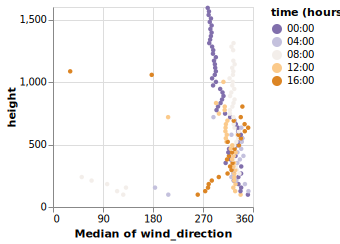

In [63]:
src = dl_wprof_df_localtime.query("height < 1600").set_index('time').loc[start_date].reset_index()
src = src[src.time.dt.hour % 4 == 0]
src['part_of_day'] = src.time.dt.hour.apply(lambda hr: 'am' if hr < 12 else 'pm')
wind_prof_chart = alt.Chart(
    src
).mark_circle(size=20).encode(
    alt.X('median(wind_direction):Q').scale(domain=[0,360]).axis(values=[0,90,180,270,360]),
    alt.Y('height:Q'),
    alt.Color('hours(time):O').scale(scheme='purpleorange'),
    # alt.Facet('part_of_day:N'),
    order='height'
).properties(
    width=200,
    height=200
)
wind_prof_chart

In [122]:
wind_direction_df = pd.DataFrame(
    sos_df_localtime.query("variable == 'dir_3m_c'").set_index('time').sort_index().loc[start_date: end_date].value.rename('SOS 3m')
).join(
    dl_wprof_df_localtime.query("height > 1000").query("height < 1600").groupby('time')['wind_direction'].median().rename('DL, 1km')
).join(
    sail_ecor_df_localtime.set_index('time')['wind_dir'].rename('SAIL 3m')
).join(
    splash_asfs_df_localtime.set_index('time')['wdir_vec_mean'].drop_duplicates().resample('30min').median().rename('SPLASH 5m')
)
wind_direction_df = wind_direction_df

In [106]:
wind_speed_df = pd.DataFrame(
    sos_df_localtime.query("variable == 'spd_3m_c'").set_index('time').sort_index().loc[start_date: end_date].value.rename('SOS 3m')
).join(
    dl_wprof_df_localtime.query("height > 1000").query("height < 1600").groupby('time')['wind_speed'].median().rename('DL, 1km')
).join(
    sail_ecor_df_localtime.set_index('time')['wind_spd'].rename('SAIL 3m')
).join(
    splash_asfs_df_localtime.set_index('time')['wspd_vec_mean'].drop_duplicates().resample('30min').median().rename('SPLASH 5m')
)
wind_speed_df = wind_speed_df

In [107]:
temp_df = pd.concat([
    sos_df_localtime.query("variable == 'T_3m_c'").set_index('time').reset_index().assign(key = 'SOS 3m').set_index('time')[[
        'key',
        'value'
    ]],
    splash_asfs_df_localtime[['time', 'temp']].set_index('time').resample('30min').mean().assign(key = 'SPLASH 5m').rename(columns={'temp':'value'}),
    sail_met_df_localtime[['time','temp_mean']].set_index('time').resample('30min').mean().assign(key = 'SAIL 3m').rename(columns={'temp_mean': 'value'})
])

In [116]:
def wind_dir_chart(date):
    return alt.Chart(
        wind_direction_df.loc[date].reset_index()
    ).transform_fold(
        wind_direction_df.columns
    ).mark_line().encode(
        alt.X('time:T').axis(labels=False).title(''),
        alt.Y('value:Q'),
        # .scale(domain=[0,360]).axis(values=[0,90,180,270,360]),
        alt.Color('key:N')
    ).properties(width=200, height=100)

def wind_spd_chart(date):
    return alt.Chart(
        wind_speed_df.loc[date].reset_index()
    ).transform_fold(
        wind_speed_df.columns
    ).mark_line().encode(
        alt.X('time:T').axis(labels=False).title(''),
        alt.Y('value:Q'),
        alt.Color('key:N')
    ).properties(width=200, height=100)

def rsw_in_chart(date):
    return alt.Chart(
        sos_df_localtime.query("variable == 'Rsw_in_9m_d'").set_index('time').loc[date].reset_index().assign(key = 'SOS 3m')
    ).mark_line().encode(
        alt.X('time:T').axis(labels=False).title(''),
        alt.Y('value:Q'),
        alt.Color('key:N')
    ).properties(width=200, height=100)

def T_chart(date):
    return alt.Chart(
        temp_df.loc[date].reset_index()
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q'),
        alt.Color('key:N')
    ).properties(width=200, height=100)

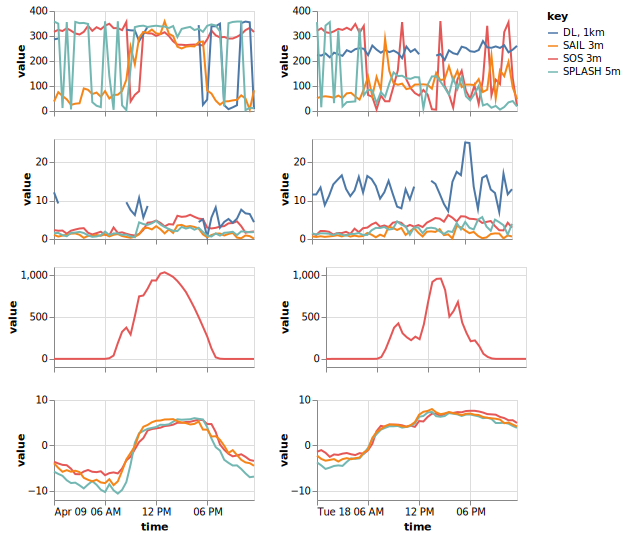

In [123]:
(
    (wind_dir_chart('20230409') | wind_dir_chart('20230418')).resolve_scale(y='shared')
    & 
    (wind_spd_chart('20230409') | wind_spd_chart('20230418')).resolve_scale(y='shared')
    &
    (rsw_in_chart('20230409') | rsw_in_chart('20230418')).resolve_scale(y='shared')
    & 
    (T_chart('20230409') | T_chart('20230418')).resolve_scale(y='shared')
).resolve_scale(color='shared', x='shared')

# Create Figure for Paper

In [ ]:
surf_scaling_sos_df = sos_df_localtime[sos_df_localtime.variable.isin([
    'tke_3m_c',
    'spd_3m_c'
])].pivot_table(index='time', columns='variable', values='value').loc[start_date: end_date]
surf_scaling_sos_df = surf_scaling_sos_df.rename(columns = {
    'spd_3m_c': 'wind_speed',
    'tke_3m_c': 'TKE'
})
surf_scaling_sos_df

In [ ]:
surf_scaling_sail_df = sail_ecor_df_localtime.set_index('time')[['wind_spd']].join(
    0.5*(sail_ecor_df.set_index('time')[['var_u', 'var_v', 'var_w']]).sum(axis=1).rename('tke')
).drop_duplicates()
surf_scaling_sail_df = surf_scaling_sail_df.rename(columns = {
    'wind_spd': 'wind_speed',
    'tke': 'TKE'
})
surf_scaling_sail_df

In [ ]:
splash_shrink = splash_asfs_df_localtime[[
    'wspd_vec_mean',
    'time',
    'sigU',
    'sigV',
    'sigW',
]].drop_duplicates()
surf_scaling_splash_df = splash_shrink.set_index('time')[['wspd_vec_mean']].join(
    (splash_shrink.set_index('time')[['sigU', 'sigV', 'sigW']]**2).sum(axis=1).rename('tke')
)
surf_scaling_splash_df = surf_scaling_splash_df.rename(columns = {
    'wspd_vec_mean': 'wind_speed',
    'tke': 'TKE'
})
surf_scaling_splash_df = surf_scaling_splash_df.resample('30min').mean()

In [ ]:
combo_surf_scaling_df = pd.concat([
        surf_scaling_sos_df.assign(site='sos'),
        surf_scaling_sail_df.assign(site='sail'),
        surf_scaling_splash_df.assign(site='splash')
    ]).reset_index()
combo_surf_scaling_df

In [ ]:
alt.Chart(
    combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('wind_speed:Q'),
    alt.Color('site:N'),
    alt.Facet('date(time):O')
).resolve_scale(x='independent').properties(height=150) &\
alt.Chart(
    combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('TKE:Q'),
    alt.Color('site:N'),
    alt.Facet('date(time):O')
).resolve_scale(x='independent').properties(height=150)

In [ ]:
src = combo_surf_scaling_df[
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 9))
        |
        (combo_surf_scaling_df.time.dt.date == dt.date(2023, 4, 18))
    ]
src['Vtke'] = src['TKE']**0.5
alt.Chart(
    src
).mark_point(size=50).encode(
    alt.X('wind_speed:Q'),
    alt.Y('Vtke:Q'),
    alt.Color('date(time):N'),
    alt.Shape('site:N')
)

Time series of wind speed stuff

In [ ]:
# Top Panel
sos_wind_speeds = sos_df_localtime.query("variable == 'spd_3m_c'").set_index('time').sort_index().loc[start_date: end_date]


sos_wind_speeds.value.plot(ax=axes[0], linestyle=':', label='Surface (tower, 3m)')
axes[0].axhline(20, color='grey')
axes[0].set_ylabel('Wind speed, (m/s)')
sondes_dots_df = sondes_df.query("alt > 4000").query("alt < 5000").groupby(['date', 'timeofday']).median().reset_index()
axes[0].scatter( sondes_dots_df.time.values, sondes_dots_df.wspd.values, marker='^', label='Synoptic (radiosonde, 1-1.5 km)', facecolors='none', edgecolors='black')
axes[0].legend()
axes[0].set_ylim(0,25)

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(7.5,6), sharex=True)

# Top Panel
sos_wind_speeds = sos_df_localtime.query("variable == 'spd_3m_c'").set_index('time').sort_index().loc[start_date: end_date]

dl_wprof_df_localtime.query("height > 1000").query("height < 2000").groupby('time')['wind_speed'].median().plot(ax=axes[0], label='Synoptic (lidar, 1-1.5 km)')
sos_wind_speeds.value.plot(ax=axes[0], linestyle=':', label='Surface (tower, 3m)')
axes[0].axhline(20, color='grey')
axes[0].set_ylabel('Wind speed, (m/s)')
sondes_dots_df = sondes_df.query("alt > 4000").query("alt < 5000").groupby(['date', 'timeofday']).median().reset_index()
axes[0].scatter( sondes_dots_df.time.values, sondes_dots_df.wspd.values, marker='^', label='Synoptic (radiosonde, 1-1.5 km)', facecolors='none', edgecolors='black')
axes[0].legend()
axes[0].set_ylim(0,25)

# Bottom Panel
sos_wind_directions = sos_df_localtime.query("variable == 'dir_3m_c'").set_index('time').sort_index().loc[start_date: end_date]

dl_wprof_df_localtime.query("height > 1000").query("height < 1500").groupby('time')['wind_direction'].median().plot(ax=axes[1], label='Synoptic (lidar, 1-1.5 km)')
sos_wind_directions.value.plot(ax=axes[1], linestyle=':', label='Surface (tower, 3m)')
# Calculate median wind direction from radiosondes
sondes_dots_df = sondes_df.query("alt > 4000").query("alt < 5000").groupby(['date', 'timeofday']).median().reset_index()
axes[1].scatter( sondes_dots_df.time.values, sondes_dots_df.deg.values, marker='^', label='Synoptic (radiosonde, 1-1.5 km)', facecolors='none', edgecolors='black')
axes[1].set_ylabel('Wind direction (˚)')
axes[1].set_yticks([0, 90, 180, 270, 360])
axes[1].legend()
axes[1].fill_between(x= sos_wind_directions.index.values, y1=185, y2=265, color='grey', alpha=0.25)
axes[1].fill_between(x= sos_wind_directions.index.values, y1=275, y2=355, color='darkgrey', alpha=0.15)
# axes[1].text(x='2023-03-08T06:30:00.000000000', y=305, s='Cross-valley', fontweight='bold', color='darkgrey', fontsize=16)  # BEGIN:
# axes[1].text(x='2023-03-08T06:30:00.000000000', y=215, s='Along-valley', fontweight='bold', color='darkgrey', fontsize=16)  # END:
# plt.xlim('20221221 0000', '202212222 0000')

In [ ]:
src = dl_wprof_df_localtime.query("height > 1000").query("height < 2000").dropna().groupby('time')[['wind_direction', 'wind_speed']].median().reset_index()
src['day_of_month'] = src['time'].dt.day
src['time_of_day'] = src['time'].apply(lambda dt: dt.replace(day=1))
alt.Chart(
    src
).mark_circle().encode(
    alt.X('time_of_day:T').axis(title=None),
    alt.Y('wind_direction:Q').scale(domain=[180,360], clamp=True),
    alt.Color('wind_speed:Q'),
    alt.Size('wind_speed:Q'),
    alt.Facet('day_of_month', columns=5)
).properties(width=200, height = 200).resolve_scale(
    x='shared'
) 

In [ ]:
plt.figure(figsize=(15,6))
utils.modify_xarray_timezone(sos_ds['spd_3m_c'], 'UTC', 'US/Mountain').sel(time = slice(start_date, end_date)).plot()

utils.modify_xarray_timezone(sos_ds['Rsw_in_9m_d'], 'UTC', 'US/Mountain').sel(time = slice(start_date, end_date)).plot(
    ax=plt.twinx(), color='tab:orange'
)

In [ ]:
modeled_fluxes_df = pd.read_parquet("/Users/elischwat/Development/sublimationofsnow/analysis/paper1_old/coare_model_results.parquet")
modeled_fluxes_df = modeled_fluxes_df.query("config == 'Tsurf_c e_sat_alduchov z0_andreas_weekly 3m'")
modeled_fluxes_df.head()

modeled_fluxes_df_localtime = utils.modify_df_timezone(
    modeled_fluxes_df.reset_index(), 'UTC', 'US/Mountain'
).set_index('time').sort_index()

In [ ]:
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
def w_h2o_to_watts(values):
    latent_heat_of_vaporization = 2838 * units("J/g")
    latent_heat_flux_meas_units = values * units("g/(m^2 * s)")
    return (latent_heat_flux_meas_units * latent_heat_of_vaporization).to("W/m^2").magnitude

In [ ]:
alt.Chart(
    sos_df_localtime.query("measurement == 'w'").query("tower == 'c'").set_index('time').sort_index().loc[start_date: end_date].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=1200)

In [ ]:
plt.figure(figsize=(15,3))

w_tc_measured_series = sos_df_localtime.query("variable == 'w_tc__3m_c'").set_index('time').sort_index()[['value']]
w_tc_measured_series.value = w_tc_to_watts(w_tc_measured_series.value.values)

w_h2o_measured_series = sos_df_localtime.query("variable == 'w_h2o__3m_c_raw'").set_index('time').sort_index()[['value']]
w_h2o_measured_series.value = w_h2o_to_watts(w_h2o_measured_series.value.values)

w_h2o_measured_series['value'].loc[start_date: end_date].plot(label='Hₗ, measured', color='tab:blue')
modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].plot(label='Hₗ, modeled', color='tab:blue', linestyle='--')

w_tc_measured_series['value'].loc[start_date: end_date].plot(label='Hₛ, measured', color='tab:orange')
modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].plot(label='Hₛ, modeled', color='tab:orange', linestyle='--')
plt.ylabel("Heat flux (W m$^{-2}$)")
plt.legend()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,3), sharey=True)

w_tc_measured_series = sos_df_localtime.query("variable == 'w_tc__3m_c'").set_index('time').sort_index()[['value']]
w_tc_measured_series.value = w_tc_to_watts(w_tc_measured_series.value.values)

w_h2o_measured_series = sos_df_localtime.query("variable == 'w_h2o__3m_c_raw'").set_index('time').sort_index()[['value']]
w_h2o_measured_series.value = w_h2o_to_watts(w_h2o_measured_series.value.values)

w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230409'].plot(label='Hₗ, measured', color='tab:blue', ax=axes[0])
modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230409'].plot(label='Hₗ, modeled', color='tab:blue', linestyle='--', ax=axes[0])
w_tc_measured_series['value'].loc[start_date: end_date].loc['20230409'].plot(label='Hₛ, measured', color='tab:orange', ax=axes[0])
modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230409'].plot(label='Hₛ, modeled', color='tab:orange', linestyle='--', ax=axes[0])

w_h2o_measured_series['value'].loc[start_date: end_date].loc['20230418'].plot(label='Hₗ, measured', color='tab:blue', ax=axes[1])
modeled_fluxes_df_localtime['hlb'].loc[start_date: end_date].loc['20230418'].plot(label='Hₗ, modeled', color='tab:blue', linestyle='--', ax=axes[1])
w_tc_measured_series['value'].loc[start_date: end_date].loc['20230418'].plot(label='Hₛ, measured', color='tab:orange', ax=axes[1])
modeled_fluxes_df_localtime['hsb'].loc[start_date: end_date].loc['20230418'].plot(label='Hₛ, modeled', color='tab:orange', linestyle='--', ax=axes[1])

plt.ylabel("Heat flux (W m$^{-2}$)")
plt.legend()

In [ ]:
plt.figure(figsize=(15,6))

w_tc_measured_series = utils.modify_df_timezone(
    sos_df.query("variable == 'w_tc__3m_c'"), 'UTC', 'US/Mountain'
).set_index('time').sort_index()[['value']]
w_tc_measured_series.value = w_tc_to_watts(w_tc_measured_series.value.values)

w_tc_measured_series.loc['20230412': '20230419'].plot()

utils.modify_df_timezone(
    modeled_fluxes_df.reset_index(), 'UTC', 'US/Mountain'
).set_index('time').sort_index()['hsb'].loc['20230412': '20230419'].plot()

In [ ]:
from metpy.constants import dry_air_density_stp
dry_air_density_stp

measured_tau_df = sos_df.query("variable == 'u*_3m_c'")
measured_tau_df['value'] =  (dry_air_density_stp * (
    measured_tau_df.value.values * units("m/s")
)**2).magnitude

utils.modify_df_timezone(
    measured_tau_df, 'UTC', 'US/Mountain'
).set_index('time').sort_index().loc['20230412': '20230419'].value.plot()
utils.modify_df_timezone(
    modeled_fluxes_df.reset_index(), 'UTC', 'US/Mountain'
).set_index('time').sort_index()['tau'].loc['20230412': '20230419'].plot()

In [ ]:
from windrose import WindroseAxes
ax = WindroseAxes.from_ax(figsize=(1.6,1.6))
ax.bar(
    dl_wprof_df.query("height < 1000").query("height > 900")['wind_direction'], 
    dl_wprof_df.query("height < 1000").query("height > 900")['wind_speed'], 
    # normed=True, opening=.9, edgecolor='white', bins=1, nsector=17,
    normed=True, opening=0.8, edgecolor="white", bins=[0,10,15]
)

ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
# ax.set_legend(loc='upper right')
ax.set_title('April 18, 1km AGL winds')

## Radiosonde

In [ ]:
from metpy.units import units

In [ ]:
sondes_df['tpot'] = metpy.calc.potential_temperature(
    sondes_df['pres'].values * units(sondes_ds['pres'].units),
    sondes_df['tdry'].values * units(sondes_ds['tdry'].units),
).magnitude

In [ ]:
alt.Chart(
    sondes_df.query('alt < 6000')[['rh', 'alt', 'date', 'timeofday']]
).mark_line().encode(
    alt.X('rh:Q'),
    alt.Y('alt:Q').scale(zero=False),
    alt.Facet('date:O', columns=5),
    alt.Color('timeofday:N'),
    order='alt'
).properties(width=200, height = 200)

In [ ]:
alt.Chart(
    sondes_df.query('alt < 6000')[['tpot', 'alt', 'date', 'timeofday']]
).mark_line().encode(
    alt.X('tpot:Q'),
    alt.Y('alt:Q').scale(zero=False),
    alt.Facet('date:O', columns=5),
    alt.Color('timeofday:N'),
    order='alt'
).properties(width=200, height = 200)

In [ ]:
utils.modify_xarray_timezone(
    sos_ds['T_3m_c'],
    'UTC',
    'US/Mountain'
).sel(time = slice('20230412 1000', '20230412 2000')).plot()
utils.modify_xarray_timezone(
    sos_ds['T_20m_c'],
    'UTC',
    'US/Mountain'
).sel(time = slice('20230412 1000', '20230412 2000')).plot()

utils.modify_xarray_timezone(
    sos_ds['w_w_w__20m_c'],
    'UTC',
    'US/Mountain'
).sel(time = slice('20230412 1000', '20230412 2000')).plot(ax=plt.twinx(), color='k')

In [ ]:
sos_df_localtime.query("variable == 'T_3m_c'").set_index('time').loc['20230412'].value.plot()
sos_df_localtime.query("variable == 'T_10m_c'").set_index('time').loc['20230412'].value.plot()
sos_df_localtime.query("variable == 'T_20m_c'").set_index('time').loc['20230412'].value.plot()

In [ ]:
sos_df_localtime.query("variable == 'temp_gradient_3m_c'").set_index('time').loc['20230412'].value.plot()
sos_df_localtime.query("variable == 'temp_gradient_10m_c'").set_index('time').loc['20230412'].value.plot()
sos_df_localtime.query("variable == 'temp_gradient_20m_c'").set_index('time').loc['20230412'].value.plot()
plt.axvline('20230412 1100')

# April 12 - vortex spectra?

In [ ]:
ds = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230412.191514.cdf")
# /Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230412.191834.cdf
# /Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230412.194513.cdf
# /Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.20230412.194834.cdf

In [ ]:
ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))

ds = ds.set_coords(['x', 'z'])

plt.figure(figsize = (10,5))
plt.xlim(-2000, 2000)
plt.ylim(0, 2000)
ds.sel(range = slice(0,2000))['radial_velocity'].plot.contourf(x='x', y='z', cmap='gist_ncar', levels=50)

In [ ]:
df = ds.sel(range = slice(0,2000)).to_dataframe()[['x', 'z', 'radial_velocity']]
df

In [ ]:
from scipy.interpolate import griddata

# Extract x, z, and radial_velocity
x = df['x'].values
z = df['z'].values
radial_velocity = df['radial_velocity'].values

# Define a regular grid for x and z
x_grid = np.linspace(x.min(), x.max(), 4000)  # Adjust grid resolution as needed
z_grid = np.linspace(z.min(), z.max(), 2000)
x_mesh, z_mesh = np.meshgrid(x_grid, z_grid)

# Interpolate radial_velocity onto the grid
radial_velocity_grid = griddata(
    (x, z), radial_velocity, (x_mesh, z_mesh), method='linear'
)

# Plot the interpolated grid (optional)
plt.contourf(x_mesh, z_mesh, radial_velocity_grid, cmap='gist_ncar', levels=50, vmin=-20, vmax=20)
plt.colorbar(label='Radial Velocity')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Interpolated Radial Velocity')
plt.show()

In [ ]:
plt.contourf(
    x_mesh[750: 1500, 250+2000: 1250+2000],
    z_mesh[750: 1500, 250+2000: 1250+2000], 
    radial_velocity_grid[750: 1500, 250+2000: 1250+2000], 
    cmap='gist_ncar', levels=50, vmin=-20, vmax=20
)
plt.colorbar(label='Radial Velocity')
plt.xlabel('x')

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:

plt.contourf(
    x_mesh[750: 1500, 250+2000: 1250+2000],
    z_mesh[750: 1500, 250+2000: 1250+2000], 
    gaussian_filter(
        radial_velocity_grid[750: 1500, 250+2000: 1250+2000], sigma=10
    ), 
    cmap='gist_ncar', levels=50, vmin=-20, vmax=20
)
plt.colorbar(label='Radial Velocity')
plt.xlabel('x')

In [ ]:
import math
# image = np.nan_to_num(
#     radial_velocity_grid[750: 1500, 250+2000: 1250+2000], 
#     nan=0.0
# )
image = gaussian_filter(
        radial_velocity_grid[750: 1500, 250+2000: 1250+2000], sigma=10
    )
image = image - np.mean(image)

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
mag = 20*np.log(np.abs(fshift))

n = int( math.ceil(image.shape[0] / 2.) * 2 )

a = np.fft.rfft(image,n, axis=0)

a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=1)/a.shape[1]

f = np.fft.rfftfreq(n)

n = int( math.ceil(image.shape[1] / 2.) * 2 )

a = np.fft.rfft(image,n,axis=1)

a = a.real*a.real + a.imag*a.imag

a = a.sum(axis=0)/a.shape[0]

f = np.fft.rfftfreq(n)

f_saved = f
a_saved = a
plt.plot(f_saved,a_saved)
plt.ylabel( 'Amplitude' )
plt.xlabel( 'Resolution' )
plt.xscale( 'log' )
plt.yscale( 'log' )
plt.legend()
# plt.xlim(0,0.04)

In [ ]:
plt.contourf(
    x_mesh[750: 1500, 750: 1250],
    z_mesh[750: 1500, 750: 1250], 
    radial_velocity_grid[750: 1500, 750: 1250], 
    cmap='gist_ncar', levels=50, vmin=-20, vmax=20
)
plt.colorbar(label='Radial Velocity')
plt.xlabel('x')

In [ ]:
import math
# image = np.nan_to_num(
#     radial_velocity_grid[750: 1500, 250: 1250], 
#     nan=0.0
# )
image = gaussian_filter(
        radial_velocity_grid[750: 1500, 750: 1250], sigma=10
    )
image = image - np.mean(image)

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)
mag = 20*np.log(np.abs(fshift))

n = int( math.ceil(image.shape[0] / 2.) * 2 )

a = np.fft.rfft(image,n, axis=0)

a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=1)/a.shape[1]

f = np.fft.rfftfreq(n)

n = int( math.ceil(image.shape[1] / 2.) * 2 )

a = np.fft.rfft(image,n,axis=1)

a = a.real*a.real + a.imag*a.imag

a = a.sum(axis=0)/a.shape[0]

f = np.fft.rfftfreq(n)

plt.plot(f,a)
plt.plot(f_saved,a_saved)
plt.ylabel( 'Amplitude' )
plt.xlabel( 'Resolution' )
plt.xscale( 'log' )
plt.yscale( 'log' )
plt.legend()
# plt.xlim(0,0.04)

# April 18 - Using RHI scan statistics to identify vorticies

In [ ]:
day_files = sorted(
    glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/*20230418*.cdf")
    +
    glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/*20230419*.cdf")
)
day_files = [f for f in day_files if f[-8:-6] in ['15', '18', '45', '48']]
len(day_files)

In [ ]:
day_files = day_files[96:96+16]

In [ ]:
ds = xr.open_dataset(day_files[9])
ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))
ds['SNR'] = ds['intensity'] - 1
ds = ds.set_coords(['x', 'z'])
ds = ds.sel(range = slice(0,2000))
ds['radial_velocity'].plot.contourf(x='x', y='z', cmap='gist_ncar', levels=50)

In [ ]:
ds['radial_velocity'] = ds.where(ds.SNR > 0.008)['radial_velocity']

In [ ]:
ds['radial_velocity'].plot.contourf(x='x', y='z', cmap='gist_ncar', levels=50)

In [ ]:
points = np.array((
    ds.x.values.flatten(),
    ds.z.values.flatten(),
)).T
values = ds.radial_velocity.values.T.flatten()
points.shape, values.shape

In [ ]:
X0, Z0 = np.meshgrid(
    np.linspace( ds.x.values.min(), ds.x.values.max(), 4000),
    np.linspace( ds.z.values.min(), ds.z.values.max(), 2000)
)
from scipy.interpolate import griddata
RV0 = griddata( points, values, (X0,Z0) , method='linear')

In [ ]:

# Create an xarray.DataArray for RV0
radial_velocity_regular = xr.DataArray(
    data=RV0,  # The 2D array of values
    dims=["z", "x"],  # Dimension names
    coords={"x": X0[1,:], "z": Z0[:,0]},  # Coordinate values
    name="radial_velocity"  # Name of the variable
)
radial_velocity_regular.plot.contourf(cmap='gist_ncar', levels=50)

In [ ]:
r_list = 15 + 30*np.array(np.arange(0,67))
theta_list = list(np.arange(0,181))
value_list = []
r_list_plotting = []
theta_list_plotting = []
for r in r_list:
    for theta in theta_list:
        r_list_plotting.append(r)
        theta_list_plotting.append(theta)
        value_list.append(
            radial_velocity_regular.interp(
                x = r * np.cos(np.deg2rad(theta)),
                z = r * np.sin(np.deg2rad(theta)),
            )
        )

In [ ]:
len(r_list_plotting), len(theta_list_plotting), len(value_list)

In [ ]:
np.array(r_list_plotting).min(), np.array(r_list_plotting).max()

In [ ]:
value_list_updated = [v.values.item() for v in value_list]

In [ ]:
np.array(theta_list_plotting).min(), np.array(theta_list_plotting).max()

In [ ]:
np.array(r_list_plotting).min(), np.array(r_list_plotting).max()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(np.deg2rad(theta_list_plotting), r_list_plotting, c=value_list_updated, s=1, cmap='gist_ncar')

# Calculate vorticity


In [ ]:
df = pd.DataFrame({
    'elevation': theta_list_plotting, 
    'range': r_list_plotting, 
    'radial_velocity': value_list_updated
})

In [ ]:
below_90_quadrant = df.query('elevation <= 90').set_index([
    'range', 'elevation'
])
above_90_quadrant = df.query('elevation > 90').set_index([
    'range', 'elevation'
])

In [ ]:
# index of range gate
# i
# index of elevation step
# k
# above_90_quadrant.loc[i, k]
Delta_Phi = np.deg2rad(1)
Delta_r = 30

i_iter = below_90_quadrant.index.get_level_values(0).unique()
k_iter = below_90_quadrant.index.get_level_values(1).unique()

In [ ]:
below_90_quadrant['tangential_velocity'] = 0
below_90_quadrant['tangential_velocity_smoothed'] = 0
below_90_quadrant['radial_velocity_filled'] = below_90_quadrant.radial_velocity.fillna(0)

In [ ]:
for k, k_value in list(enumerate(k_iter))[1:-1]:
    for i, i_value in list(enumerate(i_iter))[:-1]:
        # CALCULATE TANGENTIAL VELOCITY
        tang_vel_term1 = below_90_quadrant['tangential_velocity'].loc[i_iter[i], k_iter[k-1]] 
        tang_vel_term2 = Delta_Phi*below_90_quadrant['radial_velocity_filled'].loc[i_iter[i], k_iter[k]]
        tang_vel_term3 = ((i_value*Delta_Phi)/(2*Delta_r))*(
                below_90_quadrant['radial_velocity_filled'].loc[i_iter[i+1], k_iter[k]]
                - below_90_quadrant['radial_velocity_filled'].loc[i_iter[i-1], k_iter[k]]
            )
        below_90_quadrant['tangential_velocity'].loc[i_iter[i], k_iter[k]] = (
            tang_vel_term1 - tang_vel_term2 - tang_vel_term3           
        )

        # CALCULATE TANGENTIAL VELOCITY SMOOTHED
        S = 0.33
        tang_vel_smooth_term1 = (
            S
            *below_90_quadrant['tangential_velocity'].loc[i_iter[i-1], k_iter[k-1]]
            +
            (1 - 2*S)
            *below_90_quadrant['tangential_velocity'].loc[i_iter[i], k_iter[k-1]]
            +
            S
            *below_90_quadrant['tangential_velocity'].loc[i_iter[i+1], k_iter[k-1]]
        )
        below_90_quadrant['tangential_velocity_smoothed'].loc[i_iter[i], k_iter[k]] = (
            tang_vel_smooth_term1 - tang_vel_term2 - tang_vel_term3           
        )

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(
    np.deg2rad(below_90_quadrant.reset_index().elevation), 
    below_90_quadrant.reset_index().range, 
    c=below_90_quadrant.radial_velocity_filled, 
    s=1, 
    cmap='gist_ncar',
    vmin=-20, 
    vmax=20
)
fig.colorbar(c)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(
    np.deg2rad(below_90_quadrant.reset_index().elevation), 
    below_90_quadrant.reset_index().range, 
    c=below_90_quadrant.tangential_velocity, 
    s=1, 
    cmap='PuOr'
)
fig.colorbar(c)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(
    np.deg2rad(below_90_quadrant.reset_index().elevation), 
    below_90_quadrant.reset_index().range, 
    c=below_90_quadrant.tangential_velocity_smoothed, 
    s=1, 
    cmap='PuOr'
)
fig.colorbar(c)

In [ ]:
below_90_quadrant['vorticity'] = 0

In [ ]:
# Calculate vorticity
for k, k_value in list(enumerate(k_iter))[1:-1]:
    for i, i_value in list(enumerate(i_iter))[1:-1]:
        term_1 = (1/i_value)*(
            i_iter[i+1]*below_90_quadrant['tangential_velocity_smoothed'].loc[i_iter[i+1], k_iter[k]]
            - i_iter[i-1]*below_90_quadrant['tangential_velocity_smoothed'].loc[i_iter[i-1], k_iter[k]]
        ) / 2*Delta_r
        term_2 = (1/i_value)*(
            below_90_quadrant['radial_velocity'].loc[i_iter[i], k_iter[k+1]]
            - below_90_quadrant['radial_velocity'].loc[i_iter[i], k_iter[k-1]]
        ) / 2*Delta_Phi
        below_90_quadrant['vorticity'].loc[i_iter[i], k_iter[k]] = term_1 - term_2

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(
    np.deg2rad(below_90_quadrant.reset_index().elevation), 
    below_90_quadrant.reset_index().range, 
    c=below_90_quadrant.vorticity, 
    s=1, 
    cmap='PuOr'
)
fig.colorbar(c)